<h1><center>Chapter3: Classification</center></h1>
<h2><center>Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition <br>by Aurélien Géron</center></h2>
<h2><center>example and exercise code</center></h2>

In chapter2, we learned regression models. In this chapter, we will investigate farther machine learning algorithms but focusing on Classification models.

<h2>Data: MNIST</h2>

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


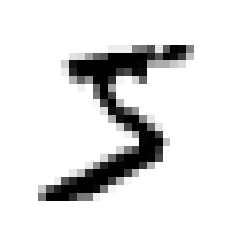

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# grab an instance's feature vector
some_digit = X[0]

# reshape its size to 28*28
some_digit_image = some_digit.reshape(28, 28)

# display
plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [5]:
# label
y[0]

'5'

In [6]:
import numpy as np

# label is a string
# Most ML algorithms take numeric values => cast y to int
y = y.astype(np.uint8)

In [7]:
# split the dataset into a training set and a testing set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

<h2>Training a Binary Classifier</h2>

In [8]:
# simplyfy the problem
y_train_5 = (y_train == 5) # True for all 5s, False for all not 5s
y_test_5 = (y_test == 5)

<h4>SGD Classifier</h4>
This classifier has the advantage of being capable of handling very large datasets efficiently.

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
sgd_clf.predict([some_digit]) 

array([ True])

<h2>Performance Measures</h2>

<h3>Measuring Accuracy Using Cross-Validation</h3>

In [11]:
# implement your own cross validation function to have more control over the process
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# each fold contains a representative ratio of each class
skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# split the training dataset
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct/len(y_pred))

0.9669
0.91625
0.96785


In [12]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [13]:
from sklearn.base import BaseEstimator

# classifes every single image in the "not-5" class
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [14]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

Although, the model guesses that an image is not a 5, it still has over 90% accuracy.
This is because only about 10% of the images are 5s, you will still be right about 90% of the time if you just classifies every image in the 'not-5 class'.

<h3> Confusion Matrix</h3>

A better way to evaluate the performance of a classifier.
It counts the number of times instances of class A are classified as class B.

In [15]:
from sklearn.model_selection import cross_val_predict

# just like cross_val_score() but it returns the predictions made on each test fold
# instead of the evaluation scores
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [16]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

[[true negatives, false positives], -negative class(non-5-images) <br>
[false negatives, true positives]]   -positive class(5-images)

In [17]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

<h3>Precision and Recall</h3>

<ul>
    <li>Precision: TP / (TP + FP) </li>
    <li>Recall: TP / (TP + FN) </li>
</ul>

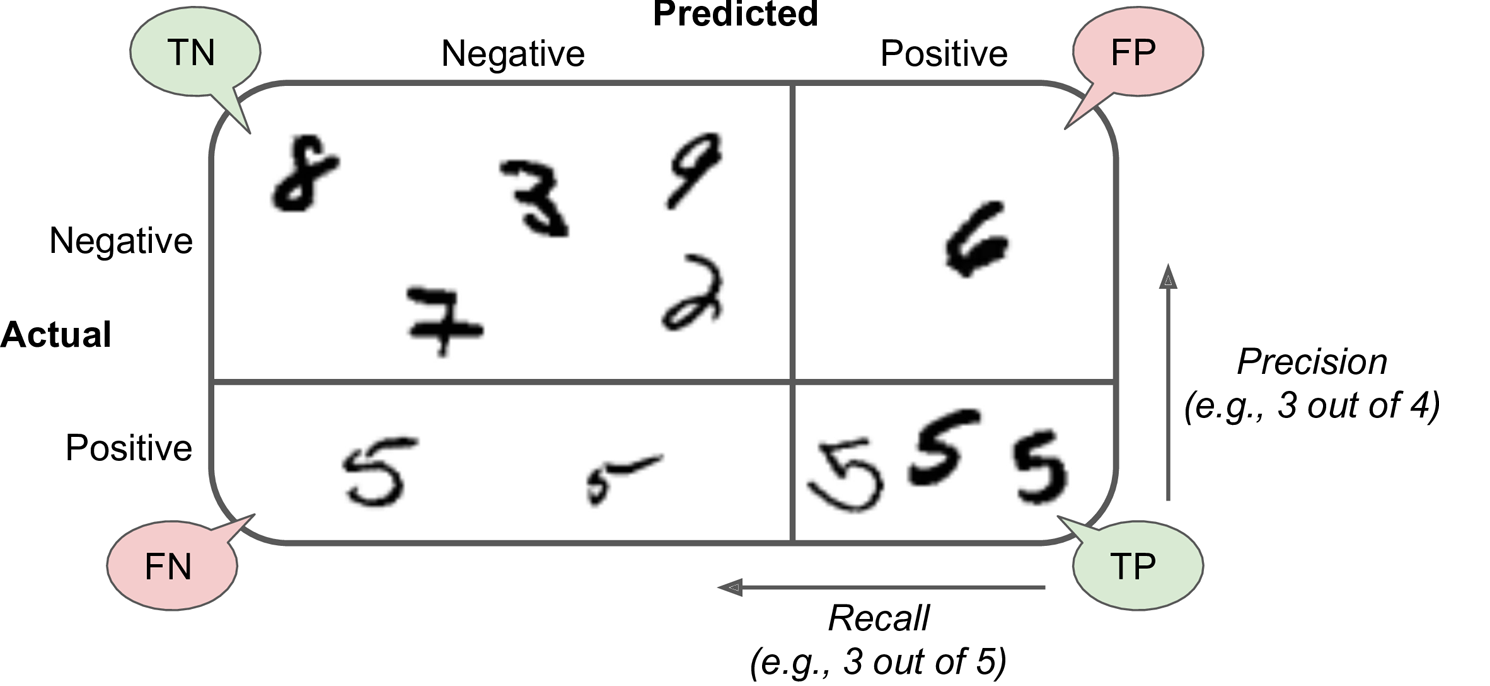

In [18]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred)) # == 3530 / (3530 + 687)
print(recall_score(y_train_5, y_train_pred)) # == 3530 / (3530 + 1891)

0.8370879772350012
0.6511713705958311


The chances are the model detects a 5 correctly is 83.7%.
Moreover, the model only detects 65.1% of the 5s.

<h4>F1 score</h4> <br>
Is used to combine precision score and recall score together.
A classifier will only get a high F1 score if both recall and precision are high.
Note that F1(harmonic mean) gives much more weight to low values.

In [19]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

<h3>Precision/Recall Trade-off</h3>

In [20]:
# use any threshold you wan to make predictions based on scores
y_scores = sgd_clf.decision_function([some_digit])
y_scores
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [21]:
# raise the threshold
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [22]:
# cross_val_predict to get the scores of all instances to decide which threshold to use
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function' )

In [23]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

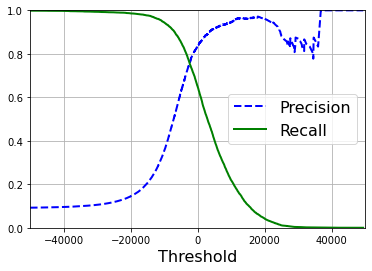

<Figure size 576x288 with 0 Axes>

In [24]:
from matplotlib.pyplot import figure

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision', linewidth=2)
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall', linewidth=2)
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel('Threshold', fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])
    
    plt.figure(figsize=(8, 4))
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

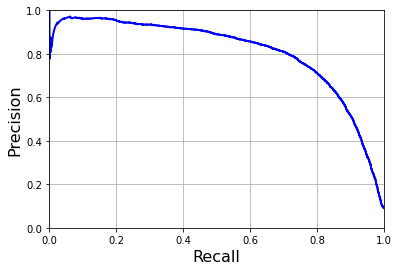

<Figure size 576x288 with 0 Axes>

In [25]:
def plot_recall_vs_precision(precisions, recalls):
    plt.plot(recalls[:-1], precisions[:-1], 'b-', linewidth=2)
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.grid(True)
    plt.axis([0, 1, 0, 1])

    plt.figure(figsize=(8, 4))
    
plot_recall_vs_precision(precisions, recalls)

In [26]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
threshold_90_precision

3370.0194991439557

In [27]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [28]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [29]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

<h3>The ROC Curve</h3>

It is very similar to the precision/recall curve.
However, ROC curve plots the true positive rate(=recall) versus the false positive rate(1-the true negative rate) instead.

In [30]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

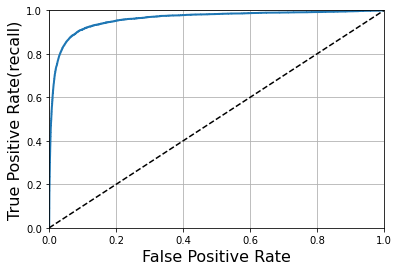

In [31]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.grid(True)
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate(recall)', fontsize=16)
    plt.axis([0,1,0,1])
    
plot_roc_curve(fpr, tpr, label=['False Positive Rate', 'True Positive Rate'])
plt.show()

Once again there is a trade off. <br>
A good classifier stays as far away from the diagonal line as possible

<h4>ROC AUC</h4>
Area Under the Curve

In [32]:
# good model has AUC close to 1
# random classifier has AUC around 0.5
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

<h4> Random Forest Classifier </h4>

In [33]:
# RandomForestClassifier does not have decision_function()
# So we will use predict_proba() method that does the similar job for us
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, 
                                   method='predict_proba')

In [34]:
import pandas as pd
pd.DataFrame(y_probas_forest)

,0,1
0,0.11,0.89
1,0.99,0.01
2,0.96,0.04
3,1.00,0.00
4,0.99,0.01
...,...,...
59995,1.00,0.00
59996,1.00,0.00
59997,0.02,0.98
59998,0.92,0.08


In [35]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

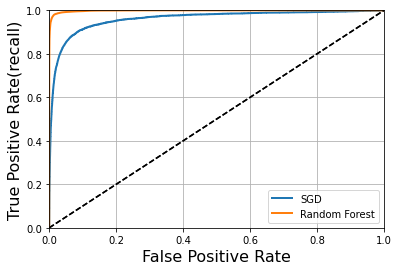

In [36]:
plot_roc_curve(fpr, tpr, label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, label='Random Forest')
plt.legend(loc='lower right')
plt.show()

In [37]:
# much better than SGD model
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [38]:
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)


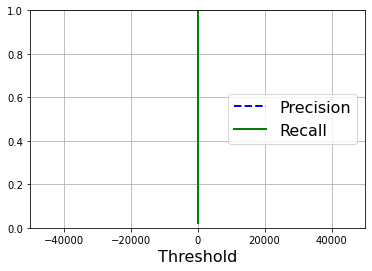

<Figure size 576x288 with 0 Axes>

In [39]:
plot_precision_recall_vs_threshold(precisions_forest, recalls_forest, thresholds_forest)

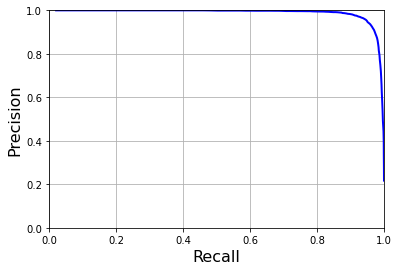

<Figure size 576x288 with 0 Axes>

In [40]:
plot_recall_vs_precision(precisions_forest, recalls_forest)

In [41]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

In [42]:
print(precision_score(y_train_5, y_train_pred_forest))
print(recall_score(y_train_5, y_train_pred_forest))

0.9905083315756169
0.8662608374838591


<h2>Multiclass Classification</h2>

SGD classifiers or support vector Machine Classifiers are strictly binary classifiers.
However, it is possible to perform multiclass Classification with multiple binary classifiers.

<h4>SCV</h4>
Note that it may work poorly with the size of the training set.

In [43]:
from sklearn.svm import SVC

# OvO strategy: binary classifier for every pair of digits
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [44]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [45]:
np.argmax(some_digit_scores)

svm_clf.classes_
svm_clf.classes_[5]

5

In [46]:
# to specifically choose a classifier between OVO and OVR
from sklearn.multiclass import OneVsRestClassifier

# OvR strategy: binary classifier for each digit (total of 10)
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])
len(ovr_clf.estimators_)

10

In [47]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [48]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [49]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

Scaling the inputs can increase accuracy.

In [50]:
# standardization (standard deviation=1, mean=0)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astye(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

AttributeError: 'numpy.ndarray' object has no attribute 'astye'

<h2>Error Analysis</h2>

In [ ]:
# produce a confusion matrix: cross_val_predict() then confusion_matrix()
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

In [ ]:
# convert the confusion matrix to an image representation
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Let's compare error rates instead of absolute numbers of errors. <br>
In order to do this, we need to divide each value in the confusion matrix by the number of images in the corresponding class.

The rows in the confusion matrix represent actual classes, while columns represent predicted classes.

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)